# Red Wine Quality Project
***
***

# Goal
***
- Predict the quality of red wines based on various physiochemical attributes

# Setup
***

In [1]:
# establishing environment
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.ticker as mtick

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

# Acquire
Acquiring the data for this project
***

In [2]:
# acquiring data from local csv
wines = pd.read_csv('winequality-red.csv')

wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Prepare
Preparing the data for this project

## Checking for nulls and data types

In [3]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


- No nulls
- Data types are appropriate for anticipated operations

## Changing spaces in column names to '_'

In [4]:
# replacing spaces with underscores in column names
wines.columns = wines.columns.str.replace(' ', '_')

## Changing all column names to be completed lowercase

In [5]:
# lowercasing all column names
wines.columns = wines.columns.str.lower()

## Outliers
After reviewing the data in-depth for outliers, I believe that the outliers are legitimate values. I don't want to remove non-erroneous data so I'm leaving the outliers in, with their original values.

## Binning Wines by Quality (1 - 5 = Bad, 6 - 10 = Good)
This variable will serve as the target variable

In [6]:
# creating boolean columns to reflect good and bad wines
wines['is_good_wine']= np.where(wines.quality >= 6, 1, 0)

# text column is useful for plotting so I don't have to customize labels
wines['good_or_bad']= np.where(wines.quality >= 6, 'good', 'bad')

# dropping 'quality' column since I have a binned version
wines.drop(columns = 'quality', inplace = True)

## Splitting data

In [7]:
# splitting data
train_validate, test = train_test_split(wines, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

## Scaling data

In [8]:
# creating list of DFs
df_list = [train, validate, test]
# creating empty list to hold names of columns to scale
cols_to_scale_l = []
# creating empty list to hold names of scaled columns
scaled_cols_l = []

# iterating through each column to be scaled of each df
for df in df_list:
    for col in df:
        if col != 'is_good_wine' and col != 'good_or_bad':
            # making temporary variable that holds current column name concatenated with '_s' at the end
            scaled_col_name = col + '_s'
            # appending col name to list
            cols_to_scale_l.append(col)
            # appending concatenated col name to list
            scaled_cols_l.append(scaled_col_name)
            # adding column with concatenated col name to current df
            df[scaled_col_name] = 0
            
# creating scaler object
scaler = sklearn.preprocessing.MinMaxScaler()

# fitting scaler to train column and scaling after
train[scaled_cols_l] = scaler.fit_transform(train[cols_to_scale_l])

# scaling data in validate and test dataframes
validate[scaled_cols_l] = scaler.transform(validate[cols_to_scale_l])
test[scaled_cols_l] = scaler.transform(test[cols_to_scale_l])

## Sorting columns

In [9]:
# moving 'is_good_wine' and 'good_or_bad' columns to end of each df
for df in df_list:
    quality_col = df.pop('is_good_wine')
    good_or_bad_col = df.pop('good_or_bad')
    df['good_or_bad'], df['is_good_wine'] = good_or_bad_col, quality_col

# Explore
Exploring the data to find insights about what drives wine quality
***

## General Exploration

### Creating Barplot that reflects percentage of each wine type (good vs bad)

In [10]:
wine_quality_counts = pd.DataFrame(train.good_or_bad.value_counts())

wine_quality_counts

,good_or_bad
good,483
bad,412


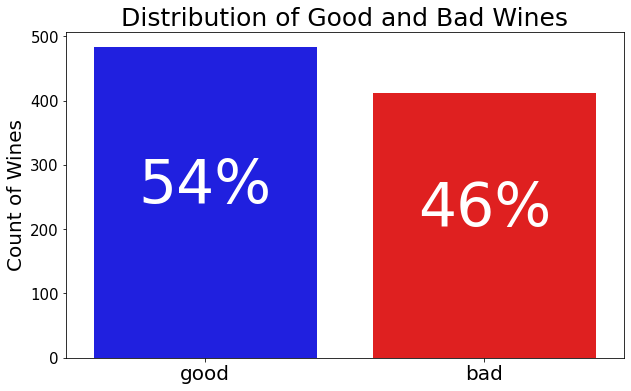

In [69]:
# creating plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data = wine_quality_counts, x = wine_quality_counts.index, y='good_or_bad', palette = ['blue', 'red'])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel('Count of Wines', fontsize = 20)
plt.title('Distribution of Good and Bad Wines', fontsize = 25)

# adding % value to middle of each column
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.0%}'.format((height / total)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- The split between bad and good wines is fairly even with only an 8% difference between them

### Creating heatmap of all scaled variables and quality

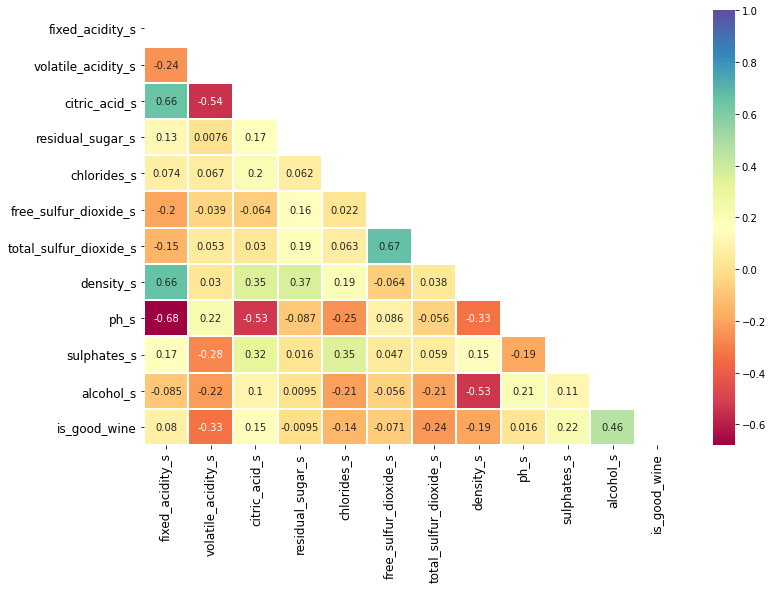

In [12]:
# creating empty list
heatmap_cols = []

# creating list of scaled variables and target variable
for col in train:
    if col[-2:] == '_s' or col == 'is_good_wine':
        heatmap_cols.append(col)

# creating df from list of columns
heatmap_df = train[heatmap_cols]

# calculating correlation values between variables
corr_matrix = heatmap_df.corr()

# creating mask to hide half duplicate variable pairings in heatmap
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# plotting heatmap
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix, cmap = 'Spectral', annot = True, mask = mask, linewidths = 1, linecolor = 'white')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

- Weak-to-Moderate negative correlation with good wine 
    - Chlorides (-.14)
    - Total_sulfure_dioxide (-.24)
    - Density (-.19)


- Weak-to-Moderate positive correlation with good wine 
    - Citric Acid (.15)
    - Sulphates (.22)


- Moderate-to-Strong negative correlation with good wine 
    - Volatile_acidity (-.33)


- Strong positive correlation with good wine 
    - Alcohol (.46)
    
    
- With these variables being noted, my initial iteration of this project will focus solely on these variables but I may explore the more weakly correlated variables at a later time

## Focused Exploration: Chlorides

### Visualization - Chlorides

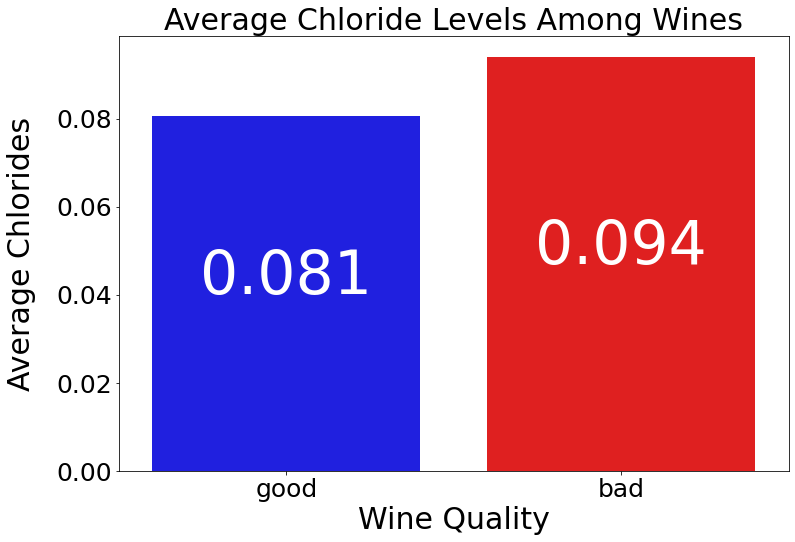

In [88]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["chlorides"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Average Chlorides', fontsize = 30, labelpad = 20)
plt.title('Average Chloride Levels Among Wines', fontsize = 30)

# adding annotations for chloride levels
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.2}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- Chloride levels are slightly higher in bad wines
    - Coincides with value in heatmap (-.14) which reflected an inverse relationship between chlorides and wine quality

### Hypothesis Test - Chlorides

H0: The average chloride levels of good wines are equal to or greater than those of bad wines
<br>
Ha: The average chloride levels of good wines are lower than those of bad wines

In [30]:
# separating chloride values into separate series'
good_wine_chlorides = train[train.is_good_wine == 1]['chlorides']
bad_wine_chlorides = train[train.is_good_wine == 0]['chlorides']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_chlorides, bad_wine_chlorides)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t < 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 8.297756394839192e-06
t = -4.330047402063806

I reject the null hypothesis


- Since p is less than alpha and t is negative (in a "less than" test), I reject the null hypothesis
- This is further evidence that bad wines have higher chloride levels

## Focused Exploration: Total Sulfur Dioxide

### Visualization - Total Sulfure Dioxide

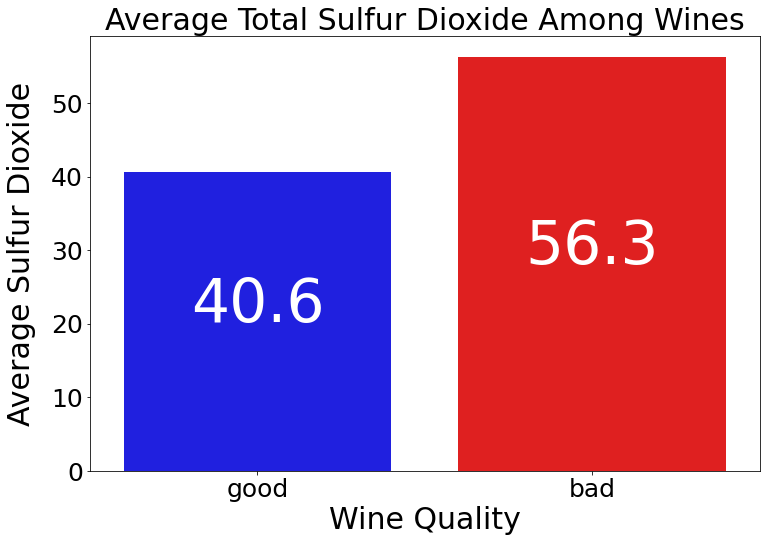

In [87]:
# creating barplot
plt.figure(figsize = (12,8))
ax = sns.barplot(x = train["good_or_bad"], y = train["total_sulfur_dioxide"], ci = None, palette = ['blue', 'red'])
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Wine Quality', fontsize = 30)
plt.ylabel('Average Sulfur Dioxide', fontsize = 30, labelpad = 15)
plt.title('Average Total Sulfur Dioxide Among Wines', fontsize = 30)

# adding annotations 
total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height / 2 , '{0:.3}'.format((height)), fontsize = 60, ha = "center", color = 'white') 

plt.show()

- Total sulfur dioxide levels are higher in bad wines
    - Coincides with value in heatmap (-.24) which reflected an inverse relationship between total sulfur dioxide and wine quality

### Hypothesis Test - Total Sulfur Dioxide
H0: The average total sulfur dioxide levels of good wines are equal to or greater than those of bad wines
<br>
Ha: The average total sulfur dioxide levels of good wines are lower than those of bad wines

In [89]:
# separating chloride values into separate series'
good_wine_tsd = train[train.is_good_wine == 1]['total_sulfur_dioxide']
bad_wine_tsd = train[train.is_good_wine == 0]['total_sulfur_dioxide']

# declaring alpha
alpha = .05

# performing 1-tailed, 2-sample, t-test
t, p = stats.ttest_ind(good_wine_tsd, bad_wine_tsd)

# printing alpha, p value, and t value
print(f'alpha = ', alpha, '\n')
print (f'p = {p/2}')
print (f't =',t)

# printing conclusion of test based on results
if t < 0 and p < alpha:
    print('\nI reject the null hypothesis')
else:
    print('\nI fail to reject the null hypothesis')

alpha =  0.05 

p = 3.9797677661960504e-13
t = -7.268015433088905

I reject the null hypothesis


- Since p is less than alpha and t is negative (in a "less than" test), I reject the null hypothesis
- This is further evidence that bad wines have higher total sulfur dioxide levels